In [2]:
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv1D, Embedding, GlobalAveragePooling1D 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

from PIL import ImageFile, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
df = pd.read_csv('../input/memotion-dataset-7k/memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.drop(columns = ['text_ocr'])
df.head()

,image_name,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


In [4]:
df = df.replace({'humour': {'not_funny': 0, 'funny': 1, 'very_funny': 2, 'hilarious':3},
            'sarcasm': {'not_sarcastic': 0, 'general': 1, 'twisted_meaning': 2, 'very_twisted': 3},
            'offensive': {'not_offensive': 0, 'slight': 1, 'very_offensive': 2, 'hateful_offensive': 3},
            'motivational': {'not_motivational': 0, 'motivational': 1},
            'overall_sentiment': {'very_negative': 0, 'negative': 1, 'neutral': 2, 'positive': 3, 'very_positive': 4}})

In [5]:
cleaned = df.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

image_name           False
text_corrected       False
humour               False
sarcasm              False
offensive            False
motivational         False
overall_sentiment    False
dtype: bool

In [6]:
width = 100
height = 100
X = []
for i in tqdm(range(cleaned.shape[0])):
    if i in [119, 4799, 6781, 6784, 6786]:
        pass
    else:
        path = '../input/memotion-dataset-7k/memotion_dataset_7k/images/'+cleaned['image_name'][i]
        img = image.load_img(path,target_size=(width,height,3))
        img = image.img_to_array(img)
        img = img/255.0
        X.append(img)
        
X = np.array(X)

 93%|█████████▎| 6501/6987 [01:22<00:05, 87.98it/s] /opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
 95%|█████████▌| 6668/6987 [01:24<00:03, 93.06it/s] /opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 6987/6987 [01:28<00:00, 79.14it/s]


In [7]:
X.shape

(6982, 100, 100, 3)

In [8]:
rows_to_drop = ['image_120.jpg',
              'image_4800.jpg',
              'image_6782.jpg',
              'image_6785.jpg',
              'image_6787.jpg',
              'image_6988.jpg',
              'image_6989.jpg',
              'image_6990.png',
              'image_6991.jpg',
              'image_6992.jpg']

In [10]:
for images in rows_to_drop:
    cleaned.drop(cleaned[cleaned['image_name'] == images].index, inplace=True)

In [12]:
Y = cleaned.iloc[:,2:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [14]:
Y = cleaned.iloc[:,2:]

In [15]:
y_train

,humour,sarcasm,offensive,motivational,overall_sentiment
619,2,0,0,1,3
349,0,0,0,0,2
3888,3,1,1,1,2
4353,0,1,0,0,2
2090,2,2,1,0,3
...,...,...,...,...,...
4297,1,0,0,1,3
995,1,1,0,0,1
3493,2,0,0,0,3
6435,1,1,0,0,3


In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [17]:
base_model_1 = tf.keras.applications.ResNet50(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')
base_model_2 = tf.keras.applications.VGG16(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')

58892288/58889256 [==============================] - 0s 0us/step


In [18]:
base_model_1.trainable = False
base_model_2.trainable = False

In [19]:
image_input = tf.keras.Input(shape=(100, 100, 3), name = 'image_input')
image_layers = data_augmentation(image_input)
image_layers = preprocess_input(image_layers)
layer_bm_1 = base_model_1(image_input, training=False)
layer_bm_1 = Conv2D(2048, kernel_size=2,padding='valid')(layer_bm_1)
layer_bm_1 = Dense(512)(layer_bm_1)
layer_bm_2 = base_model_2(image_input, training=False)
layer_bm_2 = Dense(512)(layer_bm_2)
layers = tf.keras.layers.concatenate([layer_bm_1, layer_bm_2])
image_layers = GlobalAveragePooling2D()(layers)
image_layers = Dropout(0.2, name = 'dropout_layer')(image_layers)

In [21]:
def standardization(data):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'.com', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data

cleaned['text_corrected'] = standardization(cleaned.text_corrected)

In [22]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vocab_size = 100000
sequence_length = 50

vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

text_ds = np.asarray(cleaned['text_corrected'])
vectorize_layer.adapt(tf.convert_to_tensor(text_ds))

In [25]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(cleaned.text_corrected, Y, test_size = 0.2)

In [26]:
embedding_dim=32

text_input = tf.keras.Input(shape=(None,), dtype=tf.string, name='text')
text_layers = vectorize_layer(text_input)
text_layers = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding")(text_layers)
text_layers = tf.keras.layers.Dropout(0.5)(text_layers)

text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='relu', return_sequences=True))(text_layers)
text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='relu', return_sequences=True))(text_layers)

text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
text_layers = tf.keras.layers.GlobalMaxPooling1D()(text_layers)

text_layers = tf.keras.layers.Dense(2048, activation="relu")(text_layers)
text_layers = tf.keras.layers.Dropout(0.5)(text_layers)

In [27]:
concatenate = tf.keras.layers.concatenate([image_layers, text_layers], axis=1)
semi_final_layer = tf.keras.layers.Dense(2048, activation='softmax')(concatenate)

prediction_layer_1 = tf.keras.layers.Dense(4, activation='softmax', name = 'sarcasm')
prediction_layer_2 = tf.keras.layers.Dense(4, activation='softmax', name = 'humuor')
prediction_layer_3 = tf.keras.layers.Dense(4, activation='softmax', name = 'offensive')
prediction_layer_4 = tf.keras.layers.Dense(1, activation='sigmoid', name = 'motivational')
prediction_layer_5 = tf.keras.layers.Dense(5, activation='softmax', name = 'overall')

output_1 = prediction_layer_1(semi_final_layer)
output_2 = prediction_layer_2(semi_final_layer)
output_3 = prediction_layer_3(semi_final_layer)
output_4 = prediction_layer_4(semi_final_layer)
output_5 = prediction_layer_5(semi_final_layer)

model = tf.keras.Model(inputs = [image_input, text_input] , 
                       outputs = [output_1, output_2, output_3, output_4, output_5])

In [28]:
base_learning_rate = 0.001
losses = {
      "humuor": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
      "sarcasm": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
      "offensive": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
      "motivational": tf.keras.losses.BinaryCrossentropy(from_logits=False),
      "overall": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
}
lossWeights = {
      "humuor": 1.0, 
      "sarcasm": 1.0, 
      "offensive": 1.0, 
      "motivational": 1.0,
      "overall": 1.0
}
metric = {
    "humuor": ['sparse_categorical_accuracy'],
    "sarcasm": ['sparse_categorical_accuracy'],
    "offensive": ['sparse_categorical_accuracy'],
    "motivational": ['binary_accuracy'],
    "overall": ['sparse_categorical_accuracy']
}

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss = losses,
              loss_weights= lossWeights,
              metrics=metric)

In [ ]:
history = model.fit(x = {"image_input": X_train, "text_input": X_text_train},
                    y = {"sarcasm": y_train.sarcasm, 
                         "humuor": y_train.humour, 
                         "offensive": y_train.offensive, 
                         "motivational": y_train.motivational, 
                         "overall": y_train.overall_sentiment},
                    batch_size=32,
                    epochs=1,
                    verbose=1
                   )

In [29]:
history = model.evaluate(x = {"image_input": X_test, "text_input": X_text_test},
                    y = {"sarcasm": y_test.sarcasm, 
                         "humuor": y_test.humour, 
                         "offensive": y_test.offensive, 
                         "motivational": y_test.motivational, 
                         "overall": y_test.overall_sentiment},
                    batch_size=32,
                    verbose=1
                   )

44/44 [==============================] - 4s 88ms/step - loss: 6.4612 - sarcasm_loss: 1.3863 - humuor_loss: 1.3863 - offensive_loss: 1.3863 - motivational_loss: 0.6930 - overall_loss: 1.6094 - sarcasm_sparse_categorical_accuracy: 0.4588 - humuor_sparse_categorical_accuracy: 0.3185 - offensive_sparse_categorical_accuracy: 0.3636 - motivational_binary_accuracy: 0.6593 - overall_sparse_categorical_accuracy: 0.4517


In [30]:
import matplotlib.pyplot as plt
from sklearn.utils import resample


def plot_class_distribution(data, column, title):
    class_counts = data[column].value_counts()
    class_labels = class_counts.index
    class_values = class_counts.values

    plt.figure(figsize=(8, 6))
    plt.bar(class_labels, class_values, color='skyblue')
    plt.title(f"{title} - Class Distribution", fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Class distribution for humour:
1    2450
2    2235
0    1647
3     650
Name: humour, dtype: int64 



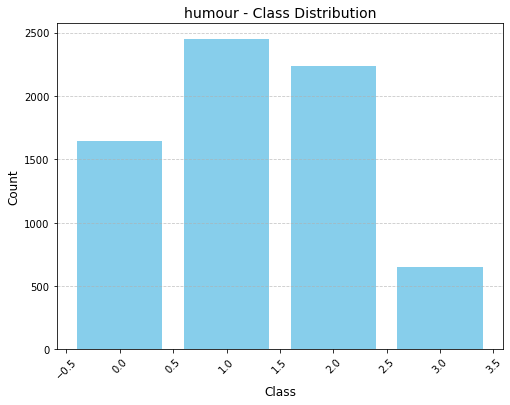

Class distribution for sarcasm:
1    3503
2    1543
0    1542
3     394
Name: sarcasm, dtype: int64 



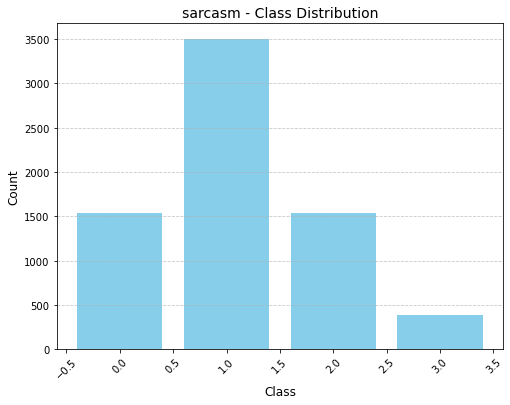

Class distribution for offensive:
0    2707
1    2590
2    1464
3     221
Name: offensive, dtype: int64 



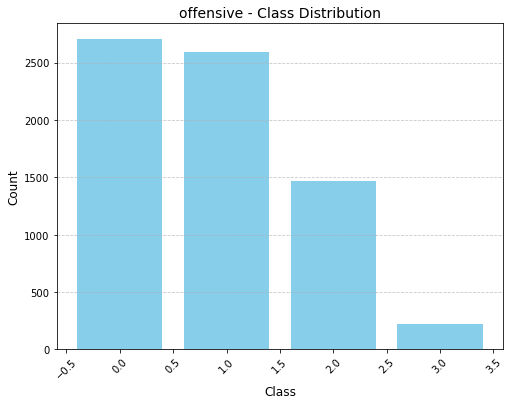

Class distribution for motivational:
0    4520
1    2462
Name: motivational, dtype: int64 



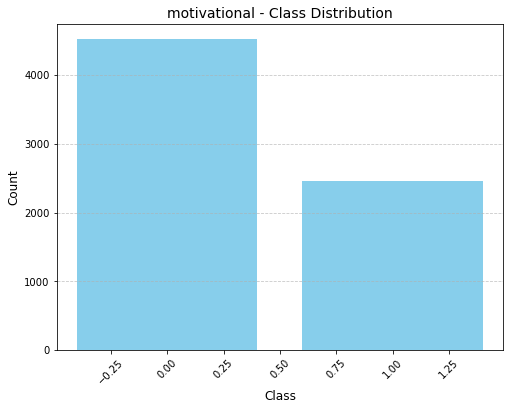

In [31]:

target_columns = ['humour', 'sarcasm', 'offensive', 'motivational']
for column in target_columns:
    print(f"Class distribution for {column}:")
    print(cleaned[column].value_counts(), "\n")
    plot_class_distribution(cleaned, column, column)



In [ ]:

def balance_dataset_lowest(df, target_columns):
    print("Balancing dataset based on the lowest class size across all columns...\n")

    
    min_class_size = min(df[col].value_counts().min() for col in target_columns)

    balanced_dfs = []

    for col in target_columns:
        print(f"Original class distribution for {col}:")
        print(df[col].value_counts(), "\n")

    
        classes = df[col].unique()

        
        for cls in classes:
            class_df = df[df[col] == cls]
            resampled_class_df = resample(
                class_df,
                replace=False,  
                n_samples=min_class_size,
                random_state=42  
            )
            balanced_dfs.append(resampled_class_df)

        print(f"Balanced class distribution for {col}:")
        print(df[col].value_counts(), "\n")

    
    balanced_df = pd.concat(balanced_dfs).drop_duplicates()
    return balanced_df

In [ ]:

balanced_cleaned = balance_dataset_lowest(cleaned, target_columns)


print(f"Final balanced dataset size: {balanced_cleaned.shape}")
for col in target_columns:
    print(f"Class distribution for {col} after balancing:")
    print(balanced_cleaned[col].value_counts(), "\n")

In [ ]:
import os
import re
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Input, Embedding, LSTM, Bidirectional, Flatten)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization, Rescaling, RandomFlip, RandomRotation


In [ ]:

df = pd.read_csv('../input/memotion-dataset-7k/memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
df = df.replace({
    'humour': {'not_funny': 0, 'funny': 1, 'very_funny': 2, 'hilarious': 3},
    'sarcasm': {'not_sarcastic': 0, 'general': 1, 'twist': 2},
    'offensive': {'not_offensive': 0, 'slightly_offensive': 1, 'very_offensive': 2},
    'motivational': {'not_motivational': 0, 'motivational': 1}

for col in ['humour', 'sarcasm', 'motivational', 'offensive']:
    df[col] = pd.to_numeric(df[col], errors='coerce')  


df.dropna(subset=['humour', 'sarcasm', 'motivational', 'offensive'], inplace=True)


def assign_class(row):
    if row['humour'] > 0:
        return 1  
    elif row['sarcasm'] > 0:
        return 0  
    elif row['motivational'] > 0:
        return 2  
    elif row['offensive'] > 0:
        return 3  
    return -1  


df['humour_class'] = df.apply(assign_class, axis=1)


df = df[df['humour_class'] != -1]

In [ ]:

def standardize_text(data):
    data = data.fillna('')  
    data = data.apply(lambda x: str(x).lower())  
    data = data.apply(lambda x: re.sub(r'\d+', '', x))  
    data = data.apply(lambda x: re.sub(r'.com', '', x, flags=re.MULTILINE)) 
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))  
    return data


df['text_corrected'] = standardize_text(df['text_corrected'])

In [ ]:

width, height = 100, 100
X_images = []

for i in tqdm(range(df.shape[0])):
    path = '../input/memotion-dataset-7k/memotion_dataset_7k/images/' + df.iloc[i]['image_name']
    img = image.load_img(path, target_size=(width, height, 3))
    img = image.img_to_array(img) / 255.0
    X_images.append(img)

X_images = np.array(X_images)
y = df['humour_class'].values

In [ ]:

X_train_images, X_test_images, y_train, y_test, X_train_text, X_test_text = train_test_split(
    X_images,
    y,
    df['text_corrected'].values,
    test_size=0.2,
    stratify=y,
    random_state=42
)


X_train_text = np.array(X_train_text)
X_test_text = np.array(X_test_text)


vocab_size = 100000
sequence_length = 50
vectorize_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vectorize_layer.adapt(X_train_text)


data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
])


preprocess_input = Rescaling(1./127.5, offset=-1)


base_model_resnet = ResNet50(input_shape=(width, height, 3), include_top=False, weights='imagenet')
base_model_resnet.trainable = True

for layer in base_model_resnet.layers[:-50]:  # Fine-tune last 50 layers
    layer.trainable = False

image_input = Input(shape=(width, height, 3), name='image_input')
x = data_augmentation(image_input)
x = preprocess_input(x)
x = base_model_resnet(x, training=True)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.4)(x)


text_input = Input(shape=(None,), dtype=tf.string, name='text_input')
y = vectorize_layer(text_input)
y = Embedding(vocab_size, 128)(y)  # Reduced embedding dimensions
y = Bidirectional(LSTM(64))(y)  # Reduced LSTM capacity
y = Flatten()(y)
y = Dense(64, activation='relu', kernel_regularizer='l2')(y)
y = Dropout(0.4)(y)

In [ ]:

concatenated = tf.keras.layers.concatenate([x, y])
z = Dense(128, activation='relu')(concatenated)
z = Dropout(0.5)(z)
output = Dense(4, activation='softmax', name='humour_classification')(z)

model = Model(inputs=[image_input, text_input], outputs=[output])
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('humour_model_best.tf', save_best_only=True, monitor='val_loss', save_format='tf')


In [ ]:
model.summary()

In [ ]:

history = model.fit(
    x={"image_input": X_train_images, "text_input": X_train_text},
    y=y_train,
    validation_split=0.2,
    epochs=30,  
    batch_size=64, 
    verbose=1,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr, early_stop, checkpoint]
)


results = model.evaluate(
    x={"image_input": X_test_images, "text_input": X_test_text},
    y=y_test,
    batch_size=32,
    verbose=1
)
print("Test Accuracy:", results[1])


class_names = ['Sarcastic', 'Humorous', 'Motivational', 'Offensive Meme']

def visualize_predictions(images, texts, labels, predictions, class_names):
    plt.figure(figsize=(15, 15))
    for i in range(min(len(images), 9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        pred_class = class_names[np.argmax(predictions[i])]
        true_class = class_names[labels[i]]
        plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
        plt.axis('off')
    plt.show()


predictions = model.predict({"image_input": X_test_images[:9], "text_input": X_test_text[:9]})
visualize_predictions(X_test_images[:9], X_test_text[:9], y_test[:9], predictions, class_names=class_names)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize


def print_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:\n")
    print(report)


y_pred_classes = np.argmax(model.predict({"image_input": X_test_images, "text_input": X_test_text}), axis=1)
print_classification_report(y_test, y_pred_classes, class_names=class_names)

In [ ]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:

num_classes = len(class_names)
y_test_bin = label_binarize(y_test, classes=range(num_classes))
y_pred_bin = model.predict({"image_input": X_test_images, "text_input": X_test_text})

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
import os
import re
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Embedding, Bidirectional, LSTM, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:

df = pd.read_csv('../input/memotion-dataset-7k/memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
df = df.replace({
    'humour': {'not_funny': 0, 'funny': 1, 'very_funny': 2, 'hilarious': 3},
    'sarcasm': {'not_sarcastic': 0, 'general': 1, 'twist': 2},
    'offensive': {'not_offensive': 0, 'slightly_offensive': 1, 'very_offensive': 2},
    'motivational': {'not_motivational': 0, 'motivational': 1}
})


for col in ['humour', 'sarcasm', 'motivational', 'offensive']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


df.dropna(subset=['humour', 'sarcasm', 'motivational', 'offensive'], inplace=True)


def assign_class(row):
    if row['humour'] > 0:
        return 1  # Humorous
    elif row['sarcasm'] > 0:
        return 0  # Sarcastic
    elif row['motivational'] > 0:
        return 2  # Motivational
    elif row['offensive'] > 0:
        return 3  # Offensive Meme
    return -1

df['text_corrected'] = df['text_corrected'].fillna('')
df['class'] = df.apply(assign_class, axis=1)
df = df[df['class'] != -1]

In [ ]:

def standardize_text(data):
    data = data.apply(lambda x: str(x).lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'.com', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data

df['text_corrected'] = standardize_text(
X_train, X_test, y_train, y_test = train_test_split(
    df['text_corrected'].values, 
    df['class'].values, 
    test_size=0.2, 
    stratify=df['class'].values, 
    random_state=42
)

# Text 
vocab_size = 20000
sequence_length = 100
vectorize_layer = TextVectorization(
    max_tokens=vocab_size, 
    output_mode='int', 
    output_sequence_length=sequence_length
)
vectorize_layer.adapt(X_train)

In [ ]:

text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text_input')
x = vectorize_layer(text_input)
x = Embedding(input_dim=vocab_size, output_dim=256)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(128))(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=text_input, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
checkpoint = ModelCheckpoint('text_classification_model_best.tf', save_best_only=True, monitor='val_loss', save_format='tf')


history = model.fit(
    x=X_train, 
    y=y_train, 
    validation_split=0.2, 
    epochs=40, 
    batch_size=64, 
    verbose=1, 
    class_weight=class_weights_dict, 
    callbacks=[reduce_lr, early_stop, checkpoint]
)

In [ ]:

results = model.evaluate(x=X_test, y=y_test, batch_size=32, verbose=1)
print("Test Accuracy:", results[1])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint('text_classification_model_best.tf', save_best_only=True, monitor='val_loss', save_format='tf')


history = model.fit(
    x=X_train, 
    y=y_train, 
    validation_split=0.2, 
    epochs=40, 
    batch_size=32, 
    verbose=1, 
    class_weight=class_weights_dict, 
    callbacks=[reduce_lr, early_stop, checkpoint]
)

In [ ]:

results = model.evaluate(x=X_test, y=y_test, batch_size=32, verbose=1)
print("Test Accuracy:", results[1])


class_names = ['Sarcastic', 'Humorous', 'Motivational', 'Offensive']

def visualize_predictions(texts, labels, predictions, class_names):
    for i in range(min(len(texts), 5)):
        true_class = class_names[labels[i]]
        pred_class = class_names[np.argmax(predictions[i])]
        print(f"Text: {texts[i]}\nTrue: {true_class}, Predicted: {pred_class}\n")

predictions = model.predict(X_test[:10])
visualize_predictions(X_test[:10], y_test[:10], predictions, class_names=class_names)

In [ ]:
from sklearn.metrics import classification_report

def print_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:\n")
    print(report)



y_pred_probs = model.predict({"text_input": X_test_text, "image_input": np.zeros((len(X_test_text), 224, 224, 3))})
y_pred = np.argmax(y_pred_probs, axis=1)  
print_classification_report(y_test, y_pred, class_names=['Sarcastic', 'Humorous', 'Motivational', 'Offensive'])

In [ ]:

def plot_roc_curve(y_true, y_pred_proba, class_names):
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


y_pred_proba = model.predict({"text_input": X_test_text})
plot_roc_curve(y_test, y_pred_proba, class_names=['Sarcastic', 'Humorous', 'Motivational', 'Offensive'])

In [32]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

In [33]:

df = pd.read_csv('../input/memotion-dataset-7k/memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
df = df.replace({
    'humour': {'not_funny': 0, 'funny': 1, 'very_funny': 2, 'hilarious': 3},
    'sarcasm': {'not_sarcastic': 0, 'general': 1, 'twist': 2},
    'offensive': {'not_offensive': 0, 'slightly_offensive': 1, 'very_offensive': 2},
    'motivational': {'not_motivational': 0, 'motivational': 1}
})


for col in ['humour', 'sarcasm', 'motivational', 'offensive']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


df.dropna(subset=['humour', 'sarcasm', 'motivational', 'offensive'], inplace=True)

In [34]:

def assign_class(row):
    if row['humour'] > 0:
        return 1  # Humorous
    elif row['sarcasm'] > 0:
        return 0  # Sarcastic
    elif row['motivational'] > 0:
        return 2  # Motivational
    elif row['offensive'] > 0:
        return 3  # Offensive Meme
    return -1

df['class'] = df.apply(assign_class, axis=1)
df = df[df['class'] != -1]

In [35]:

image_size = (224, 224)
X_images = []
for img_name in df['image_name']:
    img_path = f"../input/memotion-dataset-7k/memotion_dataset_7k/images/{img_name}"
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    X_images.append(img_array)

X_images = np.array(X_images)
y = df['class'].values

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [36]:

X_train, X_test, y_train, y_test = train_test_split(X_images, y, test_size=0.2, stratify=y, random_state=42)

In [37]:

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  

image_input = tf.keras.Input(shape=(224, 224, 3), name='image_input')
x = base_model(image_input, training=False)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=image_input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


9412608/9406464 [==============================] - 0s 0us/step


In [38]:

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint('mobilenetv2_image_classification_best.tf', save_best_only=True, monitor='val_loss', save_format='tf')


history = model.fit(
    x=X_train,
    y=y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=32,
    verbose=1,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr, early_stop, checkpoint]
)

Epoch 1/40
53/53 [==============================] - 25s 463ms/step - loss: 1.6520 - accuracy: 0.3335 - val_loss: 1.4204 - val_accuracy: 0.2979
Epoch 2/40
53/53 [==============================] - 23s 439ms/step - loss: 1.4257 - accuracy: 0.3270 - val_loss: 1.2787 - val_accuracy: 0.4161
Epoch 3/40
53/53 [==============================] - 24s 448ms/step - loss: 1.3355 - accuracy: 0.3264 - val_loss: 1.2573 - val_accuracy: 0.3759
Epoch 4/40
53/53 [==============================] - 24s 448ms/step - loss: 1.2392 - accuracy: 0.3619 - val_loss: 1.2378 - val_accuracy: 0.4232
Epoch 5/40
53/53 [==============================] - 3s 50ms/step - loss: 1.1777 - accuracy: 0.3885 - val_loss: 1.2992 - val_accuracy: 0.3688
Epoch 6/40
53/53 [==============================] - 3s 49ms/step - loss: 1.1458 - accuracy: 0.3530 - val_loss: 1.3249 - val_accuracy: 0.3168
Epoch 7/40
53/53 [==============================] - ETA: 0s - loss: 1.0693 - accuracy: 0.3525
Epoch 00007: ReduceLROnPlateau reducing learning rat

In [39]:

results = model.evaluate(x=X_test, y=y_test, batch_size=64, verbose=1)
print("Test Accuracy:", results[1])

9/9 [==============================] - 1s 81ms/step - loss: 1.1148 - accuracy: 0.4839
Test Accuracy: 0.4839319586753845


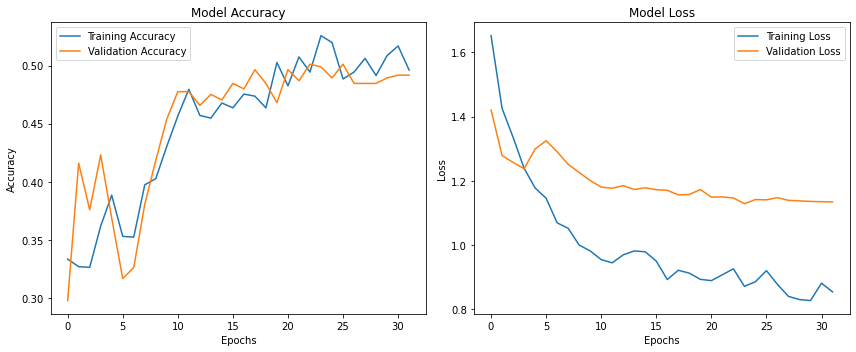

In [40]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

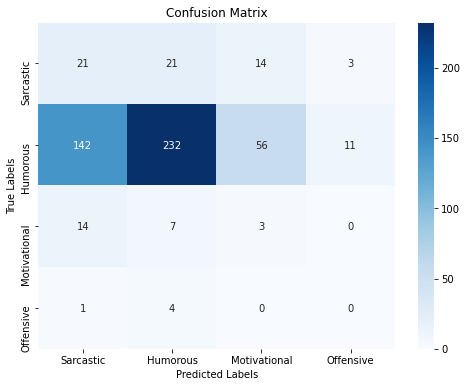

In [41]:

y_pred = np.argmax(model.predict(X_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sarcastic', 'Humorous', 'Motivational', 'Offensive'], yticklabels=['Sarcastic', 'Humorous', 'Motivational', 'Offensive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [42]:

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Sarcastic', 'Humorous', 'Motivational', 'Offensive']))

Classification Report:
              precision    recall  f1-score   support

   Sarcastic       0.12      0.36      0.18        59
    Humorous       0.88      0.53      0.66       441
Motivational       0.04      0.12      0.06        24
   Offensive       0.00      0.00      0.00         5

    accuracy                           0.48       529
   macro avg       0.26      0.25      0.22       529
weighted avg       0.75      0.48      0.57       529



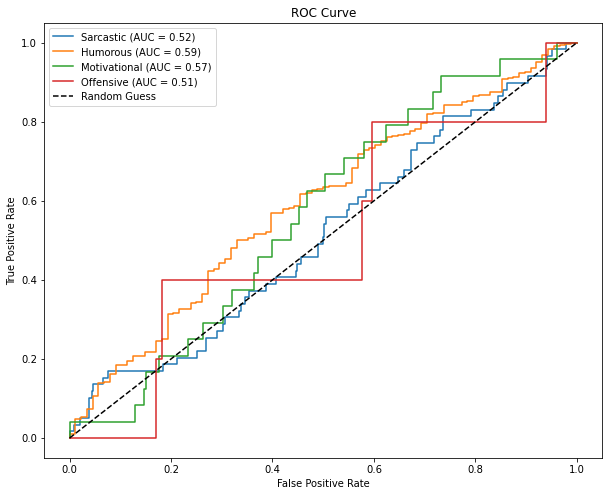

In [43]:

y_test_bin = tf.keras.utils.to_categorical(y_test, num_classes=4)
y_pred_probs = model.predict(X_test)

plt.figure(figsize=(10, 8))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{["Sarcastic", "Humorous", "Motivational", "Offensive"][i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Accuracy: 0.625585023400936
Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.13      0.11       121
           1       0.83      0.73      0.77      1069
           2       0.05      0.07      0.06        55
           3       0.03      0.08      0.05        37

    accuracy                           0.63      1282
   macro avg       0.25      0.25      0.25      1282
weighted avg       0.70      0.63      0.66      1282

Confusion Matrix:
 [[ 16  92   8   5]
 [149 779  61  80]
 [  6  42   4   3]
 [  4  29   1   3]]


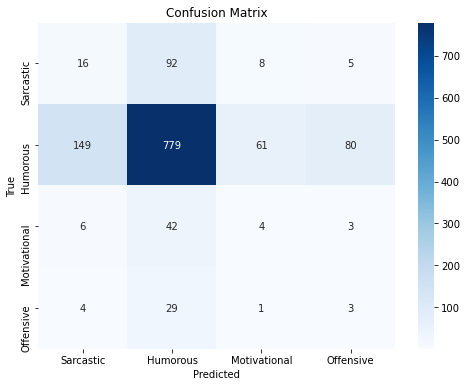

In [62]:
import os
import re
import string
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


df = pd.read_csv('../input/memotion-dataset-7k/memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
df = df.replace({
    'humour': {'not_funny': 0, 'funny': 1, 'very_funny': 2, 'hilarious': 3},
    'sarcasm': {'not_sarcastic': 0, 'general': 1, 'twist': 2},
    'offensive': {'not_offensive': 0, 'slightly_offensive': 1, 'very_offensive': 2},
    'motivational': {'not_motivational': 0, 'motivational': 1}
})


for col in ['humour', 'sarcasm', 'motivational', 'offensive']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

def assign_class(row):
    if row['humour'] > 0:
        return 1  
    elif row['sarcasm'] > 0:
        return 0  
    elif row['motivational'] > 0:
        return 2  
    elif row['offensive'] > 0:
        return 3  
    return -1


df['class'] = df.apply(assign_class, axis=1)
df = df[df['class'] != -1]

def standardize_text(data):
    data = data.apply(lambda x: str(x).lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'.com', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data

df['text_corrected'] = df['text_corrected'].fillna('')
df['text_corrected'] = standardize_text(df['text_corrected'])


image_size = (224, 224)
X_images = []
for img_name in df['image_name']:
    img_path = f"../input/memotion-dataset-7k/memotion_dataset_7k/images/{img_name}"
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    X_images.append(img_array)

X_images = np.array(X_images)


base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
image_features = base_model.predict(X_images)


tfidf_vectorizer = TfidfVectorizer(max_features=5000)
text_features = tfidf_vectorizer.fit_transform(df['text_corrected']).toarray()


combined_features = np.hstack([image_features, text_features])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, 
    df['class'].values, 
    test_size=0.2, 
    stratify=df['class'], 
    random_state=42
)


gnb = GaussianNB()
gnb.fit(X_train, y_train)


y_pred = gnb.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sarcastic', 'Humorous', 'Motivational', 'Offensive'], yticklabels=['Sarcastic', 'Humorous', 'Motivational', 'Offensive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()